# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

## Inspecting the data

any comment about data dimensionality/distribution goes here

In [13]:
import pandas as pd
import numpy as np
import os

# Suppress TensorFlow logging warnings to reduce console output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_data(path, train=True):
    df = pd.read_csv(path, encoding="ISO-8859-2")
    
    if train:
        data = df.sample(frac=1, random_state=42).values
        # Restituisci le feature (colonne da 1 a -1) e i label (ultima colonna)
        return data[:, :-1].astype(np.float32), data[:, -1]
    
    # Nel caso del test, restituisci tutto tranne la prima colonna come feature
    return df.iloc[:, 1:].values.astype(np.float32), df.iloc[:, 0].astype(str)

# Carica i dati di training e test
X_train, labels = load_data('./train.csv')
X_test, ids = load_data('./test.csv', train=False)

print(f"Training set dimensions: {X_train.shape}\nFeatures count: {X_train.shape[1]}")
print("\nFirst 5 training samples:\n", pd.DataFrame(X_train).head())
print("\nLabels distribution:\n", pd.Series(labels).value_counts())
print("\nMissing values:\n", pd.read_csv('./train.csv').isnull().sum())
print("\nSummary statistics:\n", pd.read_csv('./train.csv').describe())
print("\nTest set dimensions:", X_test.shape)


Training set dimensions: (25500, 24)
Features count: 24

First 5 training samples:
         0         1    2    3    4     5    6    7    8    9   ...       14  \
0  21870.0   70000.0  2.0  3.0  2.0  26.0  0.0  0.0  0.0  0.0  ...   8948.0   
1  15211.0  320000.0  2.0  2.0  2.0  28.0 -1.0 -1.0 -1.0 -1.0  ...    944.0   
2  20041.0   30000.0  2.0  2.0  2.0  36.0  0.0 -1.0 -1.0  0.0  ...  30452.0   
3   9190.0   20000.0  2.0  3.0  1.0  35.0  0.0  0.0  2.0  2.0  ...  18621.0   
4   6260.0   80000.0  1.0  2.0  2.0  32.0  1.0  2.0  0.0  0.0  ...  28242.0   

        15       16       17      18       19      20      21      22      23  
0   9006.0  10570.0  11421.0  2000.0   1200.0  1500.0  2000.0  1000.0  2000.0  
1    473.0   1747.0   1193.0   390.0    944.0   473.0  5000.0  1200.0   980.0  
2  29667.0  28596.0  29180.0   490.0  33299.0  1400.0   572.0   584.0   400.0  
3  18024.0  18434.0  19826.0  3000.0   1000.0     0.0   700.0  1700.0     0.0  
4  21400.0      0.0      0.0     7.0   12

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

Missing values:
 ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


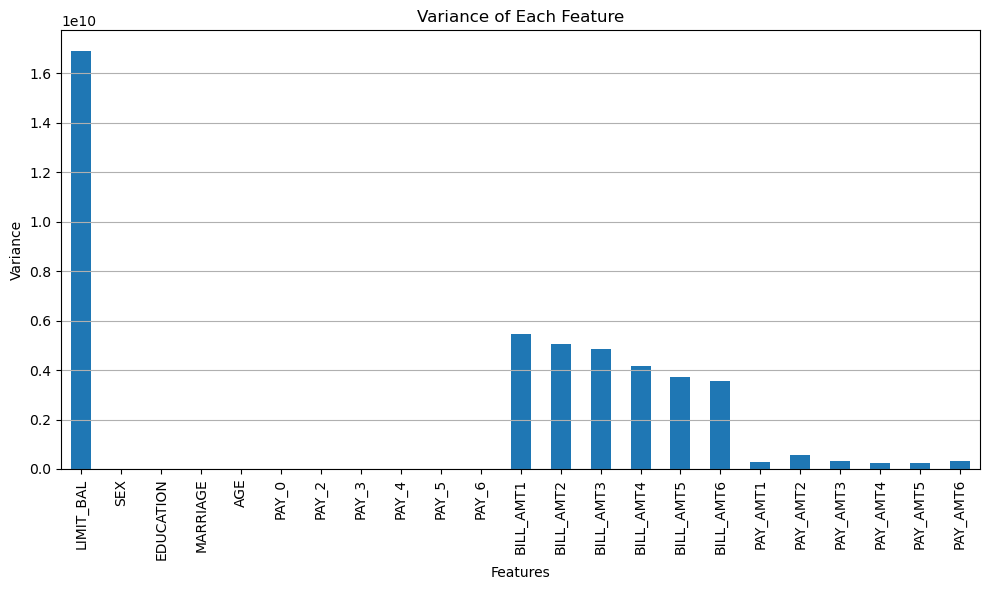

Shapes -> Train: (17850, 23), Val: (7650, 23), Encoded Train: (17850,), Encoded Val: (7650,)


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def preprocess_data(X, scaler=None):
    if scaler is None:
        scaler = StandardScaler().fit(X)
    return scaler.transform(X), scaler

# Carica i dati di training e test
df_train = pd.read_csv('./train.csv')

# Separare le etichette
labels_raw = df_train['default payment next month']

# Colonne da eliminare (inclusa la colonna ID)
columns_to_drop = ["ID"]

# Creare il DataFrame delle features
X_train_raw = df_train.drop(columns=columns_to_drop + ['default payment next month'])

# Controlla valori mancanti
print("Missing values:\n", df_train.isnull().sum())

# Visualizza la varianza delle feature
plt.figure(figsize=(10, 6))
X_train_raw.var().plot(kind='bar')
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Divisione in set di training e validazione
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, labels_raw, 
                                                  test_size=0.3, random_state=42, stratify=labels_raw)

# Ridimensionamento delle feature
X_train_scaled, scaler = preprocess_data(X_train)
X_val_scaled, _ = preprocess_data(X_val, scaler)

# Mostra la dimensione dei set
print(f"Shapes -> Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, "
      f"Encoded Train: {y_train.shape}, Encoded Val: {y_val.shape}")


## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

In [26]:
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score
from keras.layers import Input  


# Definizione del modello
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Aumento della regolarizzazione Dropout
    model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))  # Uscita per classificazione binaria
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

input_shape = X_train_scaled.shape[1]  
model = build_model(input_shape)

batch_size = 64
epochs = 32  # Aumento del numero di epoche

model.summary()

# Definizione delle callback per l'early stopping e la riduzione del learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Callback personalizzata per visualizzare i progressi durante l'addestramento
class ProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
    
    def on_epoch_end(self, epoch, logs=None):
        metrics = (f"Epoch {self.epoch + 1}/{self.params['epochs']} - "
                   f"Loss: {logs['loss']:.4f} - "
                   f"Val Loss: {logs['val_loss']:.4f} - "
                   f"Accuracy: {logs['accuracy']:.4f} - "
                   f"Val Accuracy: {logs['val_accuracy']:.4f}")
        print("\r" + metrics, end='')

# Addestramento del modello
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr, ProgressBar()],
                    verbose=1)

# Valutazione del modello sul set di validazione
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

print()
print("\nRESULTS:")
print(f"{'Validation Loss:':<20} {val_loss:.4f}")
print(f"{'Validation Accuracy:':<20} {val_accuracy:.4f}")

# Previsione e calcolo dell'F1 Score
y_pred_prob = model.predict(X_val_scaled, verbose=0) 
y_pred = (y_pred_prob > 0.5).astype(int)

f1 = f1_score(y_val, y_pred)
print(f"{'F1 Score:':<20} {f1:.4f}")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 512)            │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,225 (704.00 KB)

 Trainable params: 178,433 (697.00 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/32
279/279 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5834 - loss: 5.9970 - val_accuracy: 0.7783 - val_loss: 5.0197 - learning_rate: 1.0000e-04
Epoch 2/32
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7249 - loss: 4.7663 - val_accuracy: 0.8051 - val_loss: 4.0647 - learning_rate: 1.0000e-04
Epoch 3/32
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7748 - loss: 3.8594 - val_accuracy: 0.8149 - val_loss: 3.3104 - learning_rate: 1.0000e-04
Epoch 4/32
279/279 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7938 - loss: 3.1722 - val_accuracy: 0.8179 - val_loss: 2.7510 - learning_rate: 1.0000e-04
Epoch 5/32
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8018 - loss: 2.6527 - val_accuracy: 0.8174 - val_loss: 2.3296 - learning_rate: 1.0000e-04
Epoch 6/32
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8007 - loss: 2.2635 - val_accuracy: 0.8161 - val_loss: 2.0021 - learning_rate: 1.0000e-04
Epoch 7/32
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - ac

## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Step 1: Generate predictions on the validation set
y_val_pred_prob = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Confusion Matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(confusion)

# Step 3: Classification Report
class_report = classification_report(y_val, y_val_pred, target_names=["No Default", "Default"])
print("Classification Report:")
print(class_report)

# Step 4: Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
[[5591  354]
 [1040  665]]
Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.94      0.89      5945
     Default       0.65      0.39      0.49      1705

    accuracy                           0.82      7650
   macro avg       0.75      0.67      0.69      7650
weighted avg       0.80      0.82      0.80      7650

ROC AUC Score: 0.7732


## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [28]:
import pandas as pd

# Step 9: Importare il dataframe da test.csv e fare il clipping
test_df = pd.read_csv('test.csv')

# Clipping dei dati
test_df['EDUCATION'] = test_df['EDUCATION'].clip(lower=1, upper=4)
test_df['MARRIAGE'] = test_df['MARRIAGE'].clip(lower=1, upper=3)

for pay_col in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    test_df[pay_col] = test_df[pay_col].clip(lower=0, upper=9)

# Rimuovi la colonna 'ID', che non è una feature
if 'ID' in test_df.columns:
    test_df = test_df.drop(columns=['ID'])

# Step 10: Preparare i dati di test
X_test = test_df.copy()  # Mantieni il DataFrame per avere i nomi delle colonne

# Standardizzazione dei dati se le dimensioni corrispondono
if X_test.shape[1] == scaler.n_features_in_:
    X_test_scaled = scaler.transform(X_test)  # Usa il DataFrame per la trasformazione
else:
    raise ValueError("Impossibile standardizzare i dati: il numero di colonne non corrisponde.")

# Step 11: Fare previsioni
test_predictions_prob = model.predict(X_test_scaled)
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Step 12: Salvare le previsioni in test_predictions.csv
pd.DataFrame(test_predictions, columns=['Predicted']).to_csv('test_predictions.csv', index=False, header=False)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [29]:

# Importare le librerie necessarie
from sklearn.metrics import accuracy_score, f1_score

# Step 13: Importare le etichette corrette
true_labels_df = pd.read_csv('test_with_labels_real.csv', header=None)  # Assicurati di impostare header=None se non ci sono intestazioni
true_labels = true_labels_df[0].values  # Considerando che le etichette sono nella prima colonna

# Step 14: Importare le predizioni fatte
predictions_df = pd.read_csv('test_predictions.csv', header=None)
predictions = predictions_df[0].values  # Considerando che le predizioni sono nella prima colonna

# Step 15: Calcolare l'accuratezza e il punteggio F1
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Step 16: Stampare i risultati
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.8251
F1 Score: 0.4812


# OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify you prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).